In [255]:
import os
import glob
import json
import logging
import subprocess
import urllib
import warnings
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
from scipy.interpolate import splev,splrep
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy
import astropy.units as u
from sunpy.map import Map,MapCube
import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_tools_util

import synthesizAR
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import EbtelInterface,calculate_free_energy
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA

%matplotlib inline

# v0.1 Test of `synthesizAR` Modeling with SDO/*AIA* and *Hinode*/EIS

In this notebook, we'll model the emission from several hundred loops as it would be detected by both the Atmospheric Imaging Assembly and the Extreme Ultraviolet Imaging Spectrometer. In both cases, we'll incorporate effects due to non-equilibrium ionization.

## Field and Loop Hydrodynamics
We'll use an HMI magnetogram of active region NOAA AR 11082 as in [Viall and Klimchuk (2012)](https://ui.adsabs.harvard.edu/#abs/2012ApJ...753...35V/abstract). We'll extract 1000 streamlines from the field extrapolation with a minimum length of 10 Mm and a maximum length of 1000 Mm.  

In [2]:
ar_root = '/data/datadrive2/ar_viz/full_sdo_test/'

In [ ]:
crop = (u.Quantity([-400,-140]*u.arcsec),u.Quantity([320,540]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2010_06_19_03_06_00_tai_magnetogram.0.fits',
                             crop=crop,resample=resample)

In [ ]:
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(1000,loop_length_range=[1e+9,1e+11]*u.cm)

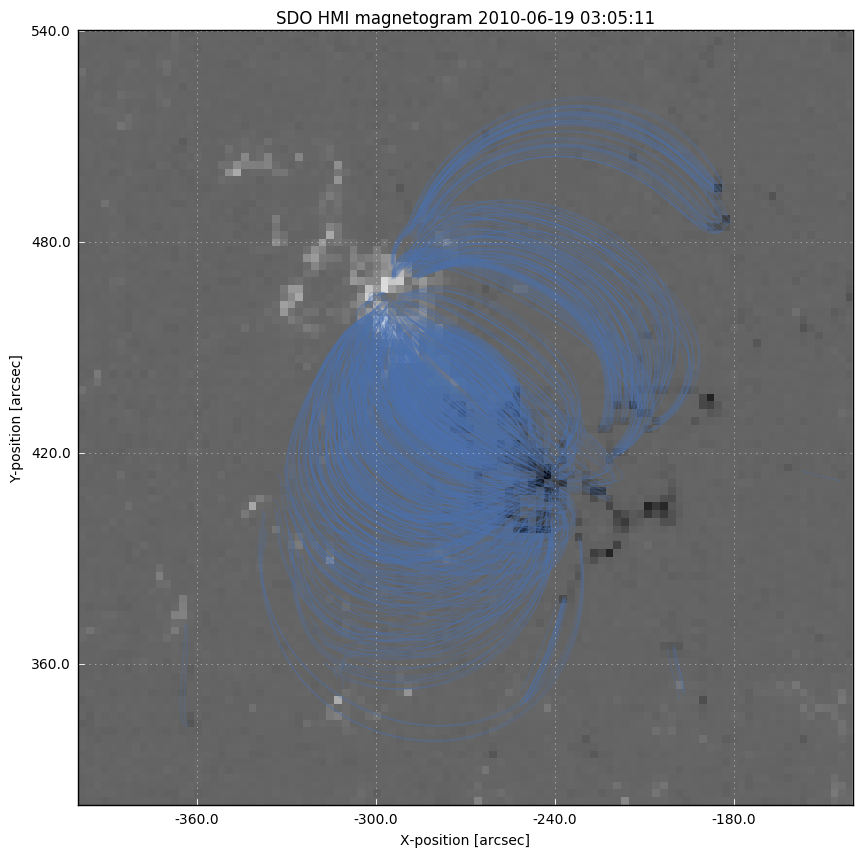

In [4]:
field.peek(alpha=0.3)

In [ ]:
field.make_loops()

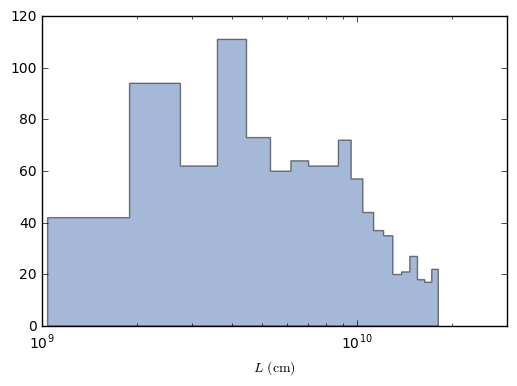

In [5]:
fig = plt.figure()
ax = fig.gca()
h = ax.hist([loop.full_length.value for loop in field.loops],
            bins=20,histtype='stepfilled',color=sns.color_palette('deep')[0],alpha=0.5)
ax.set_xscale('log')
ax.set_xlim([1e9,3e10])
ax.set_xlabel(r'$L$ $(${}$)$'.format(field.loops[0].full_length.unit.to_string(format='latex')))

Now that we have the loops, let's configure a series of hydrodynamic models using EBTEL. Each simulation will correspond to a loop in our extrapolated active region. Each loop will be heated by a single, randomly occurring nanoflare lasting 200 seconds. The amount of energy released in the event will be scaled by the local field strength.

First, configure the heating model. The `EbtelInterface` requires a heating model object that can calculate the event properties of each event. This model can be defined inline (as below) or be imported from `synthesizAR`. 

In [ ]:
class NanoflareStormModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        np.random.seed()
        
    @property
    def number_events(self):
        return 1
    
    def calculate_event_properties(self,loop):
        available_energy = calculate_free_energy(loop.field_aligned_coordinate,loop.field_strength,
                                                 stress_level=self.heating_options['stress_level'])
        rate = 2.0*available_energy/(self.number_events*(2.0*self.heating_options['duration'] 
                                                         - self.heating_options['duration_rise'] 
                                                         - self.heating_options['duration_decay']))
        #distribute start times randomly between 0 and total_time - duration
        tsr = np.random.rand(self.number_events)*(self.base_config['total_time'] - self.heating_options['duration'])
        ter = tsr + self.heating_options['duration_rise']
        tsd = ter + (self.heating_options['duration'] 
                     - self.heating_options['duration_rise'] 
                     - self.heating_options['duration_decay'])
        ted = tsr + self.heating_options['duration']
        return {'magnitude':np.array([rate]),'rise_start':tsr,'rise_end':ter,'decay_start':tsd,'decay_end':ted}

Set some of the needed heating options and then define the model interface, in this case `EbtelInterface` for the EBTEL model. Users can easily define new model interfaces for other hydrodynamic models.

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.15,
}
heating_model = NanoflareStormModel(heating_options)
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],
                                                'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model,
                            os.path.join(ar_root,'hydro_config'),
                            os.path.join(ar_root,'hydro_results'))

Now call the `configure_loop_simulations` method on the field to setup all of the loop simulations using the information from the field extrapolation.

In [ ]:
field.configure_loop_simulations(ebtel_plug)

And then run all of these loop simulations. For longer-running simulations (e.g. HYDRAD), this will be done outside the notebook, possibly using a job scheduler or on a cluster.

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

Take a quick peek at _all_ of the temperature and density profiles.

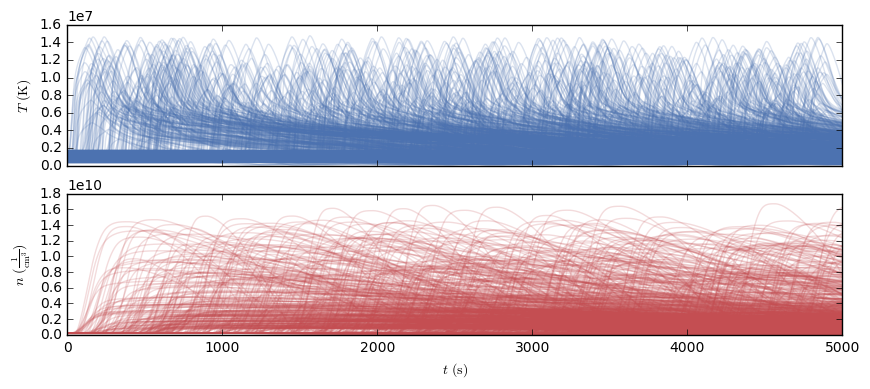

In [6]:
fig,axes = plt.subplots(2,1,figsize=(10,4),sharex=True)
for loop in field.loops:
    axes[0].plot(loop.time,loop.temperature[:,0],color=sns.color_palette('deep')[0],alpha=0.2)
    axes[1].plot(loop.time,loop.density[:,0],color=sns.color_palette('deep')[2],alpha=0.2)
axes[1].set_xlabel(r'$t$ $(${}$)$'.format(loop.time.unit.to_string(format='latex')))
axes[0].set_ylabel(r'$T$ $(${}$)$'.format(loop.temperature.unit.to_string(format='latex')))
axes[1].set_ylabel(r'$n$ $(${}$)$'.format(loop.density.unit.to_string(format='latex')))

Save the field so that it can be reloaded later.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

And restore it at this point as needed.

In [3]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

yt : [INFO     ] 2017-02-23 00:46:31,281 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-02-23 00:46:31,281 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-02-23 00:46:31,283 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2017-02-23 00:46:31,284 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2017-02-23 00:46:31,284 Parameters: cosmological_simulation   = 0.0


## Emission
`synthesizAR` contains an object for creating an emission model that will calculate the emissivity and fractional ionization for an input list of ions/transitions. 

It creates an ion object for each distinct ion that can calculate the emissivity and holds all the other needed metadata. The fractional ionization is also calculated. If explicitly calculated, this also accounts for non-equilibrium ionization. Otherwise, it falls back to an equilibrium treatment.

First, create a list of ions with the associated transitions. Note that these _must_ be available from the CHIANTI database.

In [194]:
new_linelist = [list(filter(None,line.decode('utf-8').strip('\n').split(' '))) \
                for line in urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt').readlines()[19:]]
ions = []
for line in new_linelist:
    if int(line[0]) == 1 and line[1] == 'EIS':
        el = line[2]
        ion = line[3]
        wvl = float(line[4])
        el_ion = ch_tools_util.spectroscopic2name(el,ion)
        try:
            index = next(index for (index, d) in enumerate(ions) if d["name"] == el_ion)
            ions[index]['wavelengths'] = (list(ions[index]['wavelengths'].value) + [wvl])*u.angstrom
        except StopIteration:
            ions.append({'name':el_ion,'wavelengths':[wvl]*u.angstrom})
ions.pop(1)

{'name': 'fe_9', 'wavelengths': <Quantity [ 188.497] Angstrom>}

And now sanitize the list by double checking against the CHIANTI database to make sure that all of the transition information is available. This and the above step could probably be combined.

In [195]:
for ion in ions:
    print('ion {}'.format(ion['name']))
    ch_ion = ch.ion(ion['name'])
    tmp = []
    for i,w in enumerate(ion['wavelengths'].value):
        new_wvl = min(ch_ion.Wgfa['wvl'],key=lambda x:abs(x-w))
        if abs(new_wvl - w)>0.1:
            raise ValueError('Closest wavelength {} is not within tolerance of {}'.format(new_wvl,w))
        tmp.append(new_wvl)
    tmp = tmp*ion['wavelengths'].unit
    ion['wavelengths'] = tmp

ion si_7
ion fe_10
ion fe_11
ion fe_12
ion fe_13
ion fe_15
ion s_13
ion fe_16
ion ca_17


In [196]:
ions

[{'name': 'si_7', 'wavelengths': <Quantity [ 275.3612] Angstrom>},
 {'name': 'fe_10', 'wavelengths': <Quantity [ 184.537] Angstrom>},
 {'name': 'fe_11', 'wavelengths': <Quantity [ 188.216] Angstrom>},
 {'name': 'fe_12', 'wavelengths': <Quantity [ 192.394, 195.119] Angstrom>},
 {'name': 'fe_13', 'wavelengths': <Quantity [ 202.044, 203.826] Angstrom>},
 {'name': 'fe_15', 'wavelengths': <Quantity [ 284.163] Angstrom>},
 {'name': 's_13', 'wavelengths': <Quantity [ 256.6852] Angstrom>},
 {'name': 'fe_16', 'wavelengths': <Quantity [ 262.976] Angstrom>},
 {'name': 'ca_17', 'wavelengths': <Quantity [ 192.8532] Angstrom>}]

In [265]:
u.Quantity(sorted(ions[3]['wavelengths']))

<Quantity [ 192.394, 195.119] Angstrom>

Next, create the emission model for calculating the emissivities and fractional ionizations for all of these ions.

In [ ]:
emiss_model = EmissionModel(ions,temperature=np.logspace(5,8,50)*u.K,
                            density=np.logspace(8,11,50)/u.cm**3,
                            chianti_db_filename=os.path.join(ar_root,'chianti_db.h5'),
                            energy_unit='photon')

Next, we'll calculate the emissivity for each ion. Here we define the emissivity for each transition $\lambda_i\to\lambda_j$ in units of photons s$^{-1}$ and given by the equation,

$$
\varepsilon_{ij}(n,T) = \frac{N_j(X^{+m})}{N(X^{+m})}A_{ij}
$$

In [ ]:
emiss_model.calculate_emissivity()

Then, we'll calculate the fractional ionization for each loop, incorporating non-equilibrium ionization in our calculation. 

In [ ]:
field.calculate_fractional_ionization(emiss_model,ebtel_plug,savefile=os.path.join(ar_root,'nei_populations.h5'))

Finally, we'll calculate the emission, in units of photons s$^{-1}$ sr$^{-1}$ cm$^{-3}$, for each loop, incorporating the emissivity and the fractional ionization. We define the emission as,

$$
\epsilon_{\lambda}(n,T) = \frac{1}{4\pi}0.83\mathrm{Ab}(X)\frac{N(X^{+m})}{N(X)}\varepsilon_{\lambda}(n,T)n
$$

In [ ]:
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emission.h5'))

And now save the field again.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

And save the emission model as well so that we don't have to calculate the emissivities again. Note that as long as the same ions are being used, we can continue to reuse the same emission model for multiple runs.

In [ ]:
emiss_model.save(savedir=os.path.join(ar_root,'checkpoint_emiss_model'))

And restore the emission model from a previous save.

In [7]:
emiss_model = EmissionModel.restore(os.path.join(ar_root,'checkpoint_emiss_model'))

INFO:EmissionModel:Using CHIANTI HDF5 database in /data/datadrive2/ar_viz/full_sdo_test/chianti_db.h5
INFO:EmissionModel:Creating ion si_7
INFO:EmissionModel:Creating ion fe_10
INFO:EmissionModel:Creating ion fe_11
INFO:EmissionModel:Creating ion fe_12
INFO:EmissionModel:Creating ion fe_13
INFO:EmissionModel:Creating ion fe_15
INFO:EmissionModel:Creating ion s_13
INFO:EmissionModel:Creating ion fe_16
INFO:EmissionModel:Creating ion ca_17
INFO:EmissionModel:Restoring emission model from /data/datadrive2/ar_viz/full_sdo_test/checkpoint_emiss_model


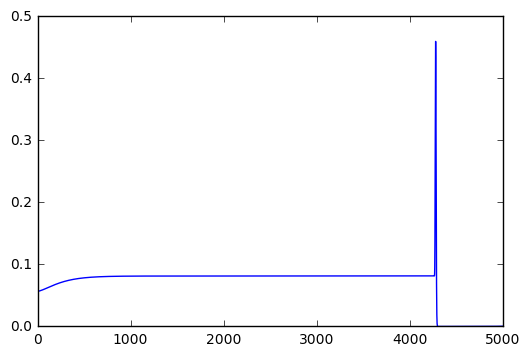

In [200]:
plt.plot(field.loops[0].time,
        field.loops[0].get_fractional_ionization('si','7')[:,0])

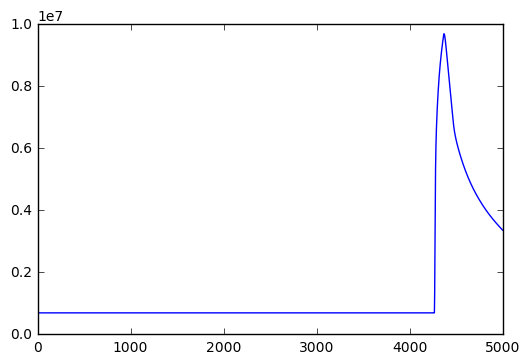

In [198]:
plt.plot(field.loops[0].time,field.loops[0].temperature[:,0])

## Instruments
Now create the instrument objects. These hold all of the properties of each of the instruments, create the needed files, hold the response function information, and have methods for creating the different data products.

We'll look at only the EIS instrument for now.

In [203]:
hinode_eis = InstrumentHinodeEIS([0,4990]*u.s)

Only use the EIS channels for which we are calculating lines.

In [204]:
new_channels = []
for channel in hinode_eis.channels:
    for wvl in emiss_model.wavelengths:
        if channel['response']['x'][0] <= wvl <= channel['response']['x'][-1]:
            new_channels.append(channel)
            break
hinode_eis.channels = new_channels

Create the observer object. This will coordinate all of the different instruments, reshape the data as needed, and create the data products.

In [205]:
observer = synthesizAR.Observer(field,[hinode_eis],ds=field._convert_angle_to_length(0.5*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scip

In [206]:
observer.build_detector_files(ar_root)

INFO:InstrumentHinodeEIS:Creating instrument file /data/datadrive2/ar_viz/full_sdo_test/Hinode_EIS_counts.h5


The process of mapping the emission and producing the data products is done in three steps:

1. Flatten all of the emission from every loop into a single data structure where each column corresponds to a given timestep of the AR. The loops are interpolated to the correct spatial and temporal resolution.
2. At each timestep, bin the emission into the appropriate 3D spatial bins, corresponding to "cells" of the 3D active region. 
3. Project these 3D AR boxes along the LOS, create a map object, and then save to a FITS file to be analyzed later.

The first step is to call all of the flatten methods. This step is **very slow**, mostly because all of the reads-writes. 

In [ ]:
observer.flatten_detector_counts()

As a first quick look, we can easily visualize both the "line-of-sight temperature" (the temperature averaged along the LOS in each grid cell) and the "line-of-sight" velocity.

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


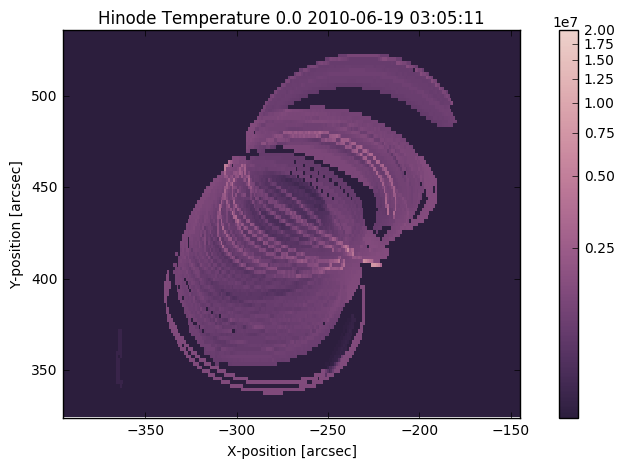

In [238]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
observer.make_temperature_map(100*u.s,hinode_eis).plot(axes=ax,
                                        norm=matplotlib.colors.SymLogNorm(2e5,vmin=5e5,vmax=2e7))
plt.colorbar()

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


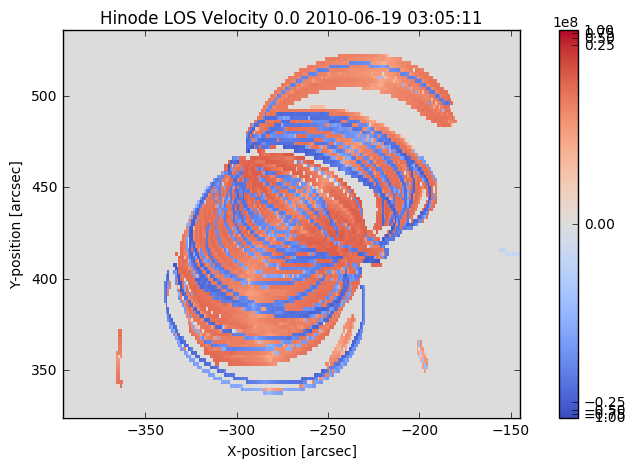

In [252]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
observer.make_los_velocity_map(4500*u.s,hinode_eis).plot(axes=ax)
plt.colorbar()

Finally, we bin the emission into a 3D structure and project it along the LOS. This will produce a series of FITS files at the appropriate cadence with all of the needed metadata.

In [40]:
observer.bin_detector_counts(ar_root)

INFO:Observer:Building data products for Hinode_EIS


## Visualization
Now let's visualize some of the results. These are just FITS files with the appropriate metadata attached. We can use the really nice `Map` object in SunPy to do most of the work of visualizing the AR itself. This makes the files very portable as well. We can work with them in IDL or Python.

First, let's look at some 2D visualizations of the integrated intensity for the entire AR.

In [260]:
eis_cube = synthesizAR.util.EISCube(os.path.join(ar_root,
                                                  'Hinode_EIS',
                                                  hinode_eis.channels[8]['name'],
                                                  'map_t{:06d}.fits'.format(200)))

OSError: [Errno 24] Too many open files: '/data/datadrive2/ar_viz/full_sdo_test/Hinode_EIS/S_XIII_256.685/map_t000200.fits'

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


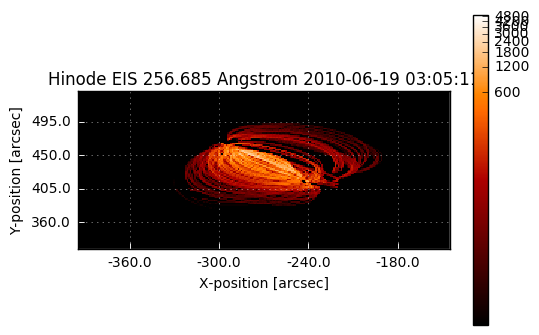

In [82]:
eis_cube.integrated_intensity.peek(norm=matplotlib.colors.SymLogNorm(0.1,vmin=1,vmax=5000))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


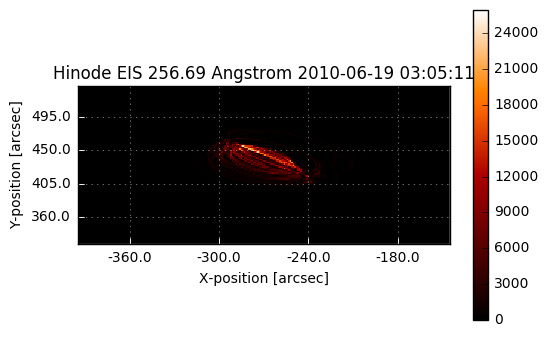

In [210]:
eis_cube[10].peek()

In [191]:
def plot_eis_frame(time):
    i_time = np.where(hinode_eis.observing_time==time)
    if len(i_time[0])==0:
        raise ValueError('{} is not a valid timestamp'.format(time))
    i_time = i_time[0][0]
    fig = plt.figure(figsize=(12,7.75))
    plt.subplots_adjust(right=0.87)
    cax = fig.add_axes([0.88, 0.14, 0.025, 0.75])
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    x_world_text = -390.0*u.arcsecond
    y_world_text = 330.0*u.arcsecond
    for i,channel in enumerate(hinode_eis.channels):
        eis_cube = synthesizAR.util.EISCube(os.path.join(ar_root,'Hinode_EIS',channel['name'],
                                                          'map_t{:06d}.fits'.format(i_time)))
        integrated_map = eis_cube.integrated_intensity
        ax = fig.add_subplot(4,3,i+1,projection=integrated_map)
        im = integrated_map.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1,vmax=10000),annotate=False)
        el,ion,wvl = channel['name'].split('_')
        #ax.set_title(r'{} {} {} $\mathrm{{\AA}}$'.format(el,ion,wvl))
        x_pixel,y_pixel = integrated_map.data_to_pixel(x_world_text,y_world_text)
        ax.text(x_pixel.value,y_pixel.value,
                r'{} {} {} $\mathrm{{\AA}}$'.format(el,ion,wvl),
                fontsize=10,
                color='w')
        if i<9:
            ax.coords[0].set_ticklabel_visible(False)
            ax.coords[0].set_ticks_visible(False)
        else:
            ax.set_xlabel(r'$x$ ({})'.format(u.Unit(integrated_map.meta['cunit1'])))
        if i%3==0:
            ax.set_ylabel(r'$y$ ({})'.format(u.Unit(integrated_map.meta['cunit2'])))
        else:
            ax.coords[1].set_ticklabel_visible(False)
            ax.coords[1].set_ticks_visible(False)
    pow_ticks = [0,1,2,3,4]
    cbar = fig.colorbar(im, ticks=10.**np.array(pow_ticks),cax=cax,format=LogFormatter(10,labelOnlyBase=False))
    cbar.set_ticklabels([r'$10^{{{}}}$'.format(t) for t in pow_ticks])

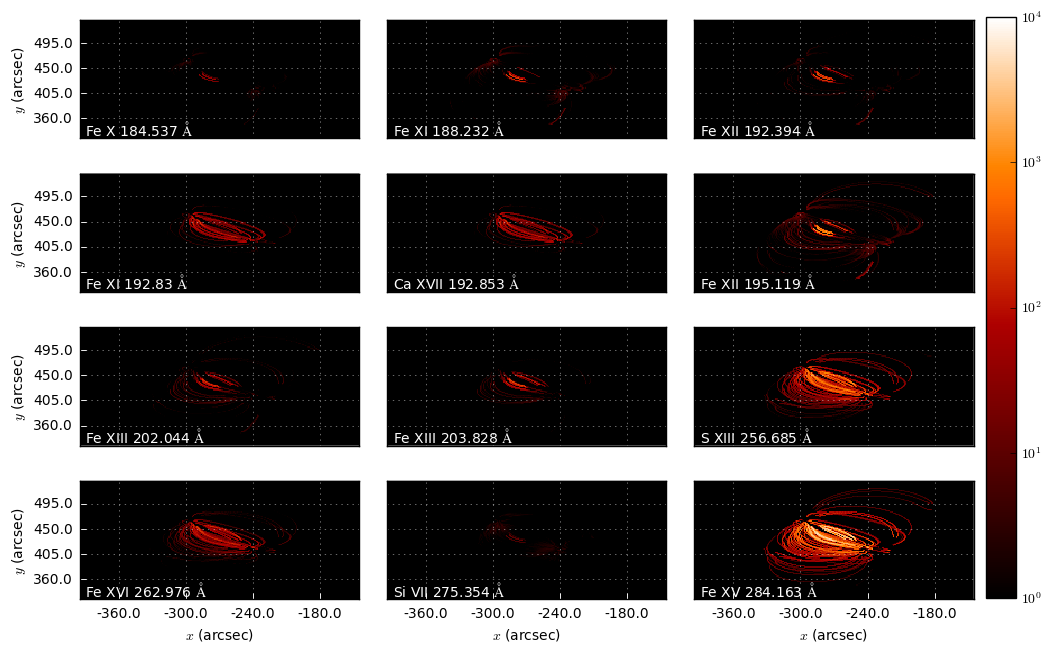

In [219]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore',astropy.utils.exceptions.AstropyUserWarning)
    plot_eis_frame(500*u.s)
    plt.show()

In [259]:
eis_cube

TypeError: __repr__ returned non-string (type list)

In [292]:
emiss_model.ions[0]['transitions'].value

array([ 275.3612])

In [294]:
for i,t in enumerate(emiss_model.ions[0]['transitions']):
    print(i,t.value)

0 275.3612
